In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import pint
import plotly.express as px
import plotly.graph_objects as go
import xarray as xr
from dask.distributed import Client
from seapopym.configuration.no_transport.parameter import ForcingParameters
from seapopym.configuration.parameters.parameter_forcing import ForcingUnit
from seapopym.standard.units import StandardUnitsLabels

from seapopym_optimization import Observation, constraint, wrapper
from seapopym_optimization.cost_function import NoTransportCostFunction
from seapopym_optimization.functional_groups import FunctionalGroupOptimizeNoTransport, Parameter
from seapopym_optimization.genetic_algorithm import GeneticAlgorithm, GeneticAlgorithmParameters
from seapopym_optimization.taylor_diagram import ModTaylorDiagram, generate_mod_taylor_diagram

## Load forcing


In [3]:
LATITUDE = 22.75
LONGITUDE = -158
TIME_START = "2005-01-01"
TIME_END = "2010-01-01"

In [4]:
path_to_forcing = "../../../../../1_data_processing/1_1_Forcing/products/Hot_cmems.zarr"
path_to_cafe = "../../../../../1_data_processing/1_1_Forcing/products/Hot_cafe.zarr"
path_to_obs = "../../../../../1_data_processing/1_1_Forcing/products/Hot_obs_filtered.zarr"
export_file_name = "SeapoPym_HOT_CAFE_optimize_E_coeff"

Load forcing.


In [5]:
data = xr.open_dataset(path_to_forcing, engine="zarr")
data["T"].attrs["units"] = StandardUnitsLabels.temperature.units
data.time.attrs["axis"] = "T"
data.npp.attrs["units"] = "mg/meter^2/day"
data = data.sel(time=slice(TIME_START, TIME_END))
_ = data.load()

cafe_npp = xr.open_dataset(path_to_cafe, engine="zarr")
cafe_npp = cafe_npp.sel(time=slice(TIME_START, TIME_END))
cafe_npp = cafe_npp.dropna("time", how="all")
cafe_npp = cafe_npp.resample(time="D").interpolate("linear")
cafe_npp.time.attrs["axis"] = "T"
_ = cafe_npp.load()

Load observations.

First I multiply the observations by the epipelagic layer depth to have a biomass in m2 rather than m3.


In [6]:
def update_layer(data: xr.DataArray, epipelagic_size):
    """Multiply biomass density of observation by the 150m which is the average epipelagic layer depth."""
    data = data.pint.quantify() * epipelagic_size
    layer_attrs = data["layer"].attrs
    data = data.assign_coords({"layer": [1]})
    data["layer"].attrs = layer_attrs
    return data


epipelagic_size = data.pelagic_layer_depth.sel(depth=1).drop_vars("depth") * pint.application_registry("meter")

obs_raw = xr.open_dataset(path_to_obs, engine="zarr")
obs_epi_depth = update_layer(obs_raw, epipelagic_size.sel(latitude=LATITUDE, longitude=LONGITUDE))
observations = [Observation(obs_epi_depth)]

Create structure for SeapoPym simulation.


In [7]:
forcing_parameters = ForcingParameters(
    temperature=ForcingUnit(forcing=data["T"], resolution=1 / 12, timestep=1),
    primary_production=ForcingUnit(forcing=cafe_npp["CAFE"], resolution=1 / 12, timestep=1),
)

2025-01-14 13:27:58,634 :: Seapodym ::  WARNING ::
|	CAFE unit is milligram / day / meter ** 2, it will be converted to kilogram / day / meter ** 2.



## Setup the parameters and the cost function


In [7]:
functional_groups = [
    FunctionalGroupOptimizeNoTransport(
        name="D1N1",
        day_layer=1,
        night_layer=1,
        energy_coefficient=Parameter("D1N1_energy_coefficient", 0.05, 0.8),
        tr_rate=Parameter("D1N1_tr_rate", -0.3, 0),
        tr_max=Parameter("D1N1_tr_max", 0, 300),
        inv_lambda_rate=Parameter("D1N1_inv_lambda_rate", 0, 0.3),
        inv_lambda_max=Parameter("D1N1_inv_lambda_max", 10, 500),
    )
]
# [1, 1, 0.1668, 10.38, -0.11, 150, 0.15]

In [8]:
cost_function = NoTransportCostFunction(
    functional_groups=functional_groups,
    forcing_parameters=forcing_parameters,
    observations=observations,
)

Set the genetic algorithm meta parameters.


In [9]:
genetic_algo_parameters = GeneticAlgorithmParameters(
    MUTPB=0.1,
    INDPB=0.2,
    ETA=5,
    CXPB=0.8,
    NGEN=10,
    POP_SIZE=500,
    cost_function_weight=(-1,),
)

Add a constraint to limit the total of energy transfert coefficient to 100%.


In [10]:
# constraint_energy = constraint.ConstraintNoTransportEnergyCoefficient(
#     parameters_name=["D1N1_energy_coefficient", "D2N1_energy_coefficient"],
#     min_energy_coef_value=0,
#     max_energy_coef_value=1,
# )

Finaly, create the Genetic Algorithm.


In [11]:
client = Client()
genetic_algo = GeneticAlgorithm(
    cost_function=cost_function,
    parameter_genetic_algorithm=genetic_algo_parameters,
    # constraint=[constraint_energy],
    client=client,
)

/Users/ash/Documents/Workspaces/PhD/Seapopym-optimisation/.venv/lib/python3.12/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 63386 instead
  warnings.warn(


And watch the magic on the Dask dashboard :


In [12]:
genetic_algo.client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:63386/status,
Dashboard: http://127.0.0.1:63386/status,Workers: 4
Total threads: 8,Total memory: 16.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:63387,Workers: 4
Dashboard: http://127.0.0.1:63386/status,Total threads: 8
Started: Just now,Total memory: 16.00 GiB
Comm: tcp://127.0.0.1:63400,Total threads: 2
Dashboard: http://127.0.0.1:63406/status,Memory: 4.00 GiB
Nanny: tcp://127.0.0.1:63390,


## Run the optimization


In [13]:
viewer = genetic_algo.optimize()

,mean,std,min,max,valid,from_previous_generation
generation,,,,,,
0,121.598333,522.343967,0.024969,6831.389583,500,0.000
1,1.996249,16.102466,0.024303,269.755559,500,0.160
2,1.755332,33.363439,0.024195,745.060290,500,0.194
3,0.339755,2.401869,0.024138,36.230548,500,0.158
4,0.618425,4.127845,0.023767,46.988742,500,0.166
5,0.473842,3.038484,0.023767,39.326878,500,0.168
6,1.266305,17.103521,0.023742,374.405247,500,0.188
7,0.287297,2.802696,0.023742,33.183700,500,0.214
8,0.127141,1.625747,0.023461,32.645101,500,0.202


Generations: 100%|██████████| 11/11 [04:53<00:00, 26.72s/it]


## Plot the results


In [14]:
viewer.stats

,mean,std,min,max,valid,from_previous_generation
generation,,,,,,
0,121.598333,522.343967,0.024969,6831.389583,500,0.000
1,1.996249,16.102466,0.024303,269.755559,500,0.160
2,1.755332,33.363439,0.024195,745.060290,500,0.194
3,0.339755,2.401869,0.024138,36.230548,500,0.158
4,0.618425,4.127845,0.023767,46.988742,500,0.166
5,0.473842,3.038484,0.023767,39.326878,500,0.168
6,1.266305,17.103521,0.023742,374.405247,500,0.188
7,0.287297,2.802696,0.023742,33.183700,500,0.214
8,0.127141,1.625747,0.023461,32.645101,500,0.202


In [15]:
viewer.fitness_evolution()

In [26]:
viewer.box_plot(3, nbest=1000)

# Generate plots at each station


In [17]:
best_individual = cost_function.functional_groups.generate_matrix(viewer.hall_of_fame.iloc[0])
print(f"Best individual: {list(best_individual[0])}")

Best individual: [1.0, 1.0, 0.7827428321787435, 20.771073641716807, -0.016997202957198754, 4.882996035640175, 0.21055672327954847]


In [10]:
best_individual = [
    [
        1.0,
        1.0,
        0.7827428321787435,
        20.771073641716807,
        -0.016997202957198754,
        4.882996035640175,
        0.21055672327954847,
    ]
]

## Run simulation


In [18]:
model_print = wrapper.model_generator_no_transport(
    forcing_parameters=forcing_parameters,
    fg_parameters=wrapper.FunctionalGroupGeneratorNoTransport(parameters=best_individual, groups_name=["D1N1"]),
)

model_print.run()

In [25]:
model_print.state

<xarray.Dataset> Size: 200kB
Dimensions:                       (functional_group: 1, depth: 3, latitude: 1,
                                   longitude: 1, time: 1827, cohort: 21)
Coordinates:
  * functional_group              (functional_group) int64 8B 0
  * depth                         (depth) int32 12B 1 2 3
  * latitude                      (latitude) float64 8B 22.75
  * longitude                     (longitude) int64 8B -158
  * time                          (time) datetime64[ns] 15kB 2005-01-01 ... 2...
  * cohort                        (cohort) int64 168B 0 1 2 3 4 ... 17 18 19 20
Data variables: (12/28)
    name                          (functional_group) <U4 16B 'D1N1'
    energy_transfert              (functional_group) float64 8B 0.7827
    inv_lambda_max                (functional_group) float64 8B 4.883
    inv_lambda_rate               (functional_group) float64 8B 0.2106
    temperature_recruitment_max   (functional_group) float64 8B 20.77
    temperature_recruitment_rate  (functional_group) float64 8B -0.017
    ...                            ...
    min_temperature               (functional_group, cohort) float64 168B 178...
    mask_temperature              (functional_group, time, latitude, longitude, cohort) bool 38kB ...
    cell_area                     (latitude, longitude) float64 8B 7.918e+07
    mortality_field               (functional_group, time, latitude, longitude) float64 15kB ...
    recruited                     (functional_group, time, latitude, longitude) float64 15kB ...
    biomass                       (functional_group, time, latitude, longitude) float64 15kB ...

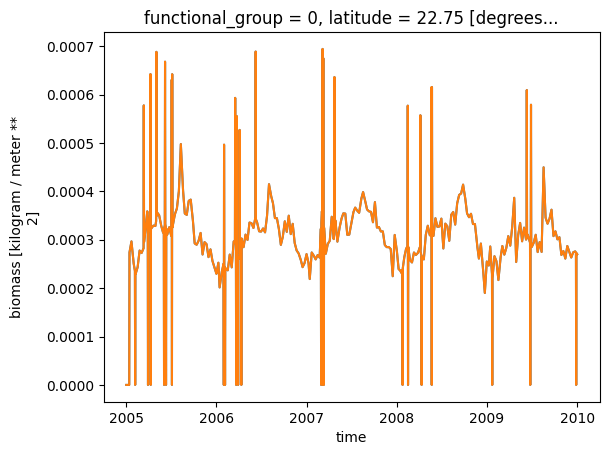

In [50]:
model_print.state.recruited.plot()
model_print.state.biomass.plot()

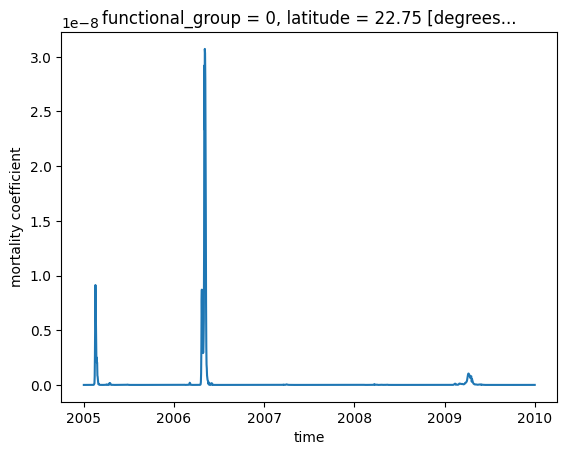

In [51]:
model_print.state.mortality_field.plot()

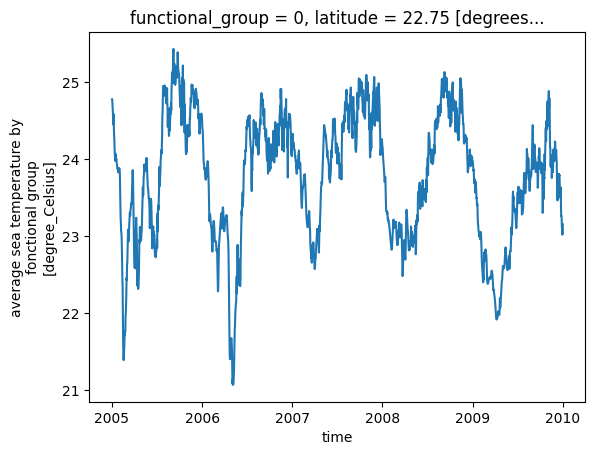

In [40]:
model_print.state.average_temperature.plot()

In [41]:
model_print.state

<xarray.Dataset> Size: 200kB
Dimensions:                       (functional_group: 1, depth: 3, latitude: 1,
                                   longitude: 1, time: 1827, cohort: 21)
Coordinates:
  * functional_group              (functional_group) int64 8B 0
  * depth                         (depth) int32 12B 1 2 3
  * latitude                      (latitude) float64 8B 22.75
  * longitude                     (longitude) int64 8B -158
  * time                          (time) datetime64[ns] 15kB 2005-01-01 ... 2...
  * cohort                        (cohort) int64 168B 0 1 2 3 4 ... 17 18 19 20
Data variables: (12/28)
    name                          (functional_group) <U4 16B 'D1N1'
    energy_transfert              (functional_group) float64 8B 0.7827
    inv_lambda_max                (functional_group) float64 8B 4.883
    inv_lambda_rate               (functional_group) float64 8B 0.2106
    temperature_recruitment_max   (functional_group) float64 8B 20.77
    temperature_recruitment_rate  (functional_group) float64 8B -0.017
    ...                            ...
    min_temperature               (functional_group, cohort) float64 168B 178...
    mask_temperature              (functional_group, time, latitude, longitude, cohort) bool 38kB ...
    cell_area                     (latitude, longitude) float64 8B 7.918e+07
    mortality_field               (functional_group, time, latitude, longitude) float64 15kB ...
    recruited                     (functional_group, time, latitude, longitude) float64 15kB ...
    biomass                       (functional_group, time, latitude, longitude) float64 15kB ...

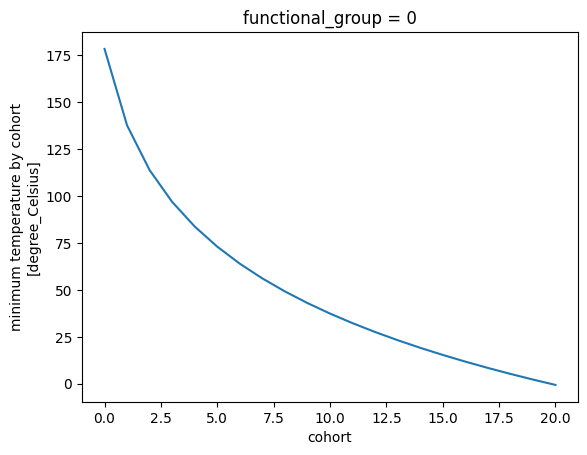

In [45]:
model_print.state.min_temperature.plot()

## Plot


In [19]:
biomass = model_print.export_biomass().pint.quantify().pint.to("mg/meter^2")
layer_depth = data.pelagic_layer_depth.sel(depth=1).drop_vars("depth") * pint.application_registry("meter")
observations = obs_epi_depth.pint.quantify().pint.to("mg/meter^2")

### Taylor Diagram


In [20]:
biomass_pandas = biomass.pint.dequantify().to_dataframe().reset_index().set_index("time")["biomass"]
observations_day_pandas = (
    observations.pint.dequantify().day.dropna("time").to_dataframe().reset_index().set_index("time")["day"]
)
observations_night_pandas = (
    observations.pint.dequantify().night.dropna("time").to_dataframe().reset_index().set_index("time")["night"]
)
layer_pandas = layer_depth.pint.dequantify().to_dataframe().reset_index().set_index("time")["pelagic_layer_depth"]
npp_pandas = cafe_npp.CAFE.to_dataframe().reset_index().set_index("time")["CAFE"]

monthly_obs_day = observations_day_pandas.resample("ME").mean()[TIME_START:TIME_END].dropna()
monthly_obs_day.index = monthly_obs_day.index.to_period("M").to_timestamp()

monthly_obs_night = observations_night_pandas.resample("ME").mean()[TIME_START:TIME_END].dropna()
monthly_obs_night.index = monthly_obs_night.index.to_period("M").to_timestamp()

monthly_pred = biomass_pandas.resample("ME").mean()[TIME_START:TIME_END].dropna()
monthly_pred.index = monthly_pred.index.to_period("M").to_timestamp()

monthly_layer = layer_pandas.resample("ME").mean()[TIME_START:TIME_END].dropna()
monthly_layer.index = monthly_layer.index.to_period("M").to_timestamp()

In [21]:
fig = go.Figure(
    layout={
        "title": "SeapoPym Daily Biomass (CAFE npp) and Observations : HOT station",
        "xaxis": {"title": "Time"},
        "yaxis": {"title": "Biomass . Epipelagic layer depth (mg/m^2)"},
    }
)


fig.add_trace(
    go.Scatter(
        x=observations_day_pandas.index,
        y=observations_day_pandas,
        fill=None,
        mode="lines",
        line={"color": "red", "width": 1},
        name="Observations (day)",
    )
)

fig.add_trace(
    go.Scatter(
        x=observations_night_pandas.index,
        y=observations_night_pandas,
        fill="tonexty",
        mode="lines",
        line={"color": "rgba(180, 180, 180, 0.2)", "width": 1},
        name="Observations (night)",
    )
)
fig.add_trace(
    go.Scatter(
        x=biomass_pandas.index,
        y=biomass_pandas,
        fill=None,
        mode="lines",
        line={"color": "black"},
        name="Predictions",
    )
)
fig.add_trace(
    go.Scatter(
        x=npp_pandas.index,
        y=npp_pandas,
        fill=None,
        mode="lines",
        line={"color": "purple", "dash": "dash"},
        name="CAFE NPP (mg/m^2/day)",
    )
)

fig.add_trace(
    go.Scatter(
        x=layer_pandas.index,
        y=layer_pandas,
        fill=None,
        mode="lines",
        line={"color": "green", "width": 1, "dash": "dash"},
        name="Epipelagic layer",
    )
)

fig.update_traces(
    yaxis="y2",
    selector={"name": "Epipelagic layer"},
    line={"color": "green", "width": 1, "dash": "dash"},
)

fig.update_layout(yaxis2={"title": "Layer Depth (m)", "overlaying": "y", "side": "right"})

fig.show()

In [22]:
fig = go.Figure(
    layout={
        "title": "SeapoPym Monthly Biomass (CAFE npp) and Observations : HOT station",
        "xaxis": {"title": "Time"},
        "yaxis": {"title": "Biomass . Epipelagic layer depth (mg/m^2)"},
    }
)


fig.add_trace(
    go.Scatter(
        x=monthly_obs_day.index,
        y=monthly_obs_day,
        fill=None,
        mode="lines",
        line={"color": "red", "width": 1},
        name="Observations (day)",
    )
)

fig.add_trace(
    go.Scatter(
        x=monthly_obs_night.index,
        y=monthly_obs_night,
        fill="tonexty",
        mode="lines",
        line={"color": "rgba(180, 180, 180, 0.2)", "width": 1},
        name="Observations (night)",
    )
)
fig.add_trace(
    go.Scatter(
        x=monthly_pred.index,
        y=monthly_pred,
        fill=None,
        mode="lines",
        line={"color": "black"},
        name="Predictions",
    )
)
fig.add_trace(px.line(monthly_layer).data[0])
fig.update_traces(
    yaxis="y2",
    selector={"name": "pelagic_layer_depth"},
    line={"color": "green", "width": 1, "dash": "dash"},
)
fig.update_layout(yaxis2={"title": "Layer Depth (m)", "overlaying": "y", "side": "right"})

fig.show()

In [23]:
fig.write_html(f"Biomass_{export_file_name}.html")

NameError: name 'sc' is not defined

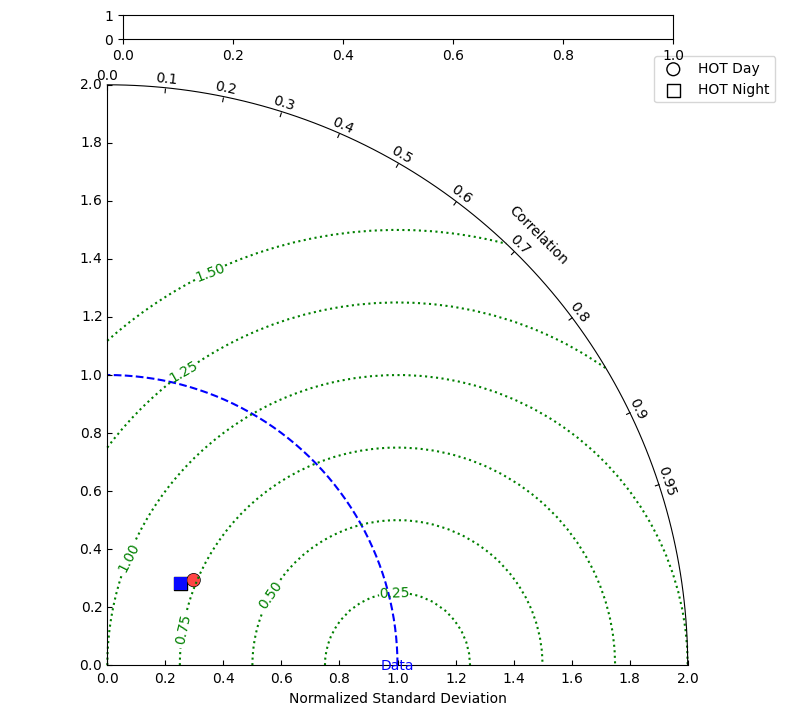

In [24]:
diagram = ModTaylorDiagram()

all_model = [monthly_pred, monthly_pred]
all_obs = [monthly_obs_day, monthly_obs_night]

all_names = ["HOT Day", "HOT Night"]

for model, obs, name in zip(all_model, all_obs, all_names):
    diagram = generate_mod_taylor_diagram(diagram, obs=obs, model=model[obs.index], name=name)
diagram.plot()
plt.title("Taylor Diagram for Seapodym model at HOT station with CAFE NPP")

# export the figure
plt.savefig(f"Taylor_{export_file_name}.png")

plt.show()

In [24]:
diagram.get_stats().to_csv(f"Stats_{export_file_name}.csv", index=False)
diagram.get_stats()

,name,correlation_coefficient,normalized_standard_deviation,bias,normalized_root_mean_square_deviation
0,HOT Day,0.712412,0.417678,0.539897,0.761142
1,HOT Night,0.668085,0.378439,-0.715382,0.798472
